## Imports

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.datasets import cifar10  #
from keras.models import Sequential  # Model type to be used
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import np_utils
import tensorflow as tf
from manifold_angles import ManifoldAngles

## Define functions

In [4]:
def create_model():
  model = Sequential()
  model.add(Conv2D(50, kernel_size=(28,28), input_shape=(28,28,1), activation='PReLU',use_bias=False, kernel_initializer='random_uniform',padding='valid'))
  model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
  model.add(Dense(10, activation='softmax', kernel_initializer= 'random_uniform'))

  return model

In [5]:
@tf.function
def get_hessian1(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
  loss = lossfunc(model(input),target)
  return tf.hessians(loss, input)

In [6]:
@tf.function
def get_hessian2(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
  with tf.GradientTape() as t2:
    t2.watch(input)
    with tf.GradientTape() as t1:
      t1.watch(input)
      loss = lossfunc(model(input),target)
    g=t1.gradient(loss,input)
  return t2.jacobian(g,input)

# mnist

#### train sequential model for classifying mnist data:

In [9]:
(X_train, train_y), (X_test, test_y) = mnist.load_data()

X_train = X_train / 255
X_test = X_test/ 255

Y_train = np_utils.to_categorical(train_y, 10)
Y_test = np_utils.to_categorical(test_y, 10)

indices = np.random.choice(X_train[train_y==0].shape[0],10000,replace=True)
s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(X_train[train_y==0][indices]))
print(np.sum(np.cumsum(s ** 2) / np.sum(s ** 2) < 0.99))

nt = create_model()
nt.summary()
nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
history  = nt.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=1, batch_size = 128)
print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")


184
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 1, 50)          39250     
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
469/469 [==============================] - 1s 2ms/step - loss: 0.5651 - categorical_accuracy: 0.8584 - val_loss: 0.2842 - val_categorical_accuracy: 0.9203
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.2546 - categorical_accuracy: 0.9281 - val_loss: 0.2221 - val_categoric

### get hessian matrix of model

In [10]:
hessian_list = []
lossfunc = tf.keras.losses.CategoricalCrossentropy()
for i in range(X_train.shape[0]):
  hessian_list.append(np.linalg.norm(get_hessian2(nt, X_train[i:i+1], Y_train[i:i+1], lossfunc=lossfunc)[0]))
hessian_list = np.array(hessian_list)

### compute curvature of inputs based on manifold metric

In [11]:
input_class_curvatures = []
# define curvatures list
for y_class in range(10):
  lowersize = 50
  s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(X_train[train_y==y_class]))
  layerdata = (u[:,:lowersize]*s[:lowersize]).numpy()
  tf.print('layer quality: ', tf.norm(s[:lowersize]) / tf.norm(s))
  del s,u,v

  layerfeatlist = [layerdata]
  results, manifold_neighbour_angle_sum =  ManifoldAngles(layerfeatlist, classsize= 1,neighboursize1=10 ,dim_reduc_size=5,fileloc = "None")

  input_class_curvatures.append(np.array(manifold_neighbour_angle_sum))

layer quality:  0.974430561
start: 
--layer time:  14.555251836776733
--angle time:  44.163193941116333
Average reduction quality:  0.694660246
endtime:  58.733676910400391
layer quality:  0.983819127
start: 
--layer time:  16.384155035018921
--angle time:  50.4023859500885
Average reduction quality:  0.733106196
endtime:  66.8028290271759
layer quality:  0.958277524
start: 
--layer time:  13.66945219039917
--angle time:  45.4783980846405
Average reduction quality:  0.68175447
endtime:  59.165106058120728
layer quality:  0.961578727
start: 
--layer time:  14.40579891204834
--angle time:  46.336446046829224
Average reduction quality:  0.676717103
endtime:  60.758038997650146
layer quality:  0.961857
start: 
--layer time:  13.520603895187378
--angle time:  44.053282976150513
Average reduction quality:  0.68898648
endtime:  57.589030027389526
layer quality:  0.957259119
start: 
--layer time:  12.37103009223938
--angle time:  41.539653062820435
Average reduction quality:  0.677526116
endti

### get predictions for each input

In [12]:
Y_predicted = nt.predict(X_train)

### compute curvature of network outputs based on manifold metric

In [13]:
# define curvatures list
output_class_curvatures = []
for y_class in range(10):
  layerfeatlist = [Y_predicted[train_y == y_class]]
  results, manifold_neighbour_angle_sum = ManifoldAngles(layerfeatlist, classsize=1, neighboursize1=10, dim_reduc_size=5, fileloc = "None")
  output_class_curvatures.append(np.array(manifold_neighbour_angle_sum))

start: 
--layer time:  14.291187047958374
--angle time:  44.920653104782104
Average reduction quality:  0.970280647
endtime:  59.229979991912842
start: 
--layer time:  13.519181966781616
--angle time:  51.287960052490234
Average reduction quality:  0.949813187
endtime:  64.824786901474
start: 
--layer time:  11.413861989974976
--angle time:  45.80794095993042
Average reduction quality:  0.974325
endtime:  57.239989995956421
start: 
--layer time:  11.685024976730347
--angle time:  46.603233098983765
Average reduction quality:  0.980838358
endtime:  58.303746938705444
start: 
--layer time:  10.847594022750854
--angle time:  44.113389015197754
Average reduction quality:  0.968657196
endtime:  54.976398944854736
start: 
--layer time:  9.9595110416412354
--angle time:  41.007172107696533
Average reduction quality:  0.975181
endtime:  50.982146024703979
start: 
--layer time:  11.178426027297974
--angle time:  44.806397914886475
Average reduction quality:  0.970058084
endtime:  56.03611898422

In [14]:
# define test data sizes to reduce to
datasizes = np.logspace(3.699, 0.699, 20).astype('int')

### more function definitions

In [15]:
def shuffle_data(X: np.ndarray, Y: np.ndarray, seed: int):
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(Y)

In [16]:
def get_reduced_datasets(data_size: int, X: np.ndarray, Y: np.ndarray, order_method: str, curvature_set='input', dataset='mnist'):

  _input_curvatures = input_class_curvatures if dataset == 'mnist' else cifar_class_curvatures
  _output_curvatures = output_class_curvatures if dataset == 'mnist' else cifar_output_class_curvatures
  _train_y = train_y if dataset == 'mnist' else cifar_train_y[:, 0]
  _hessian_list = hessian_list if dataset == 'mnist' else cifar_hessian_list
  
  _curvature_set = _input_curvatures if curvature_set == 'input' else _output_curvatures

  for y_class in range(10):
    class_indices = _train_y == y_class
    keep_indices = None
    if order_method == 'hessian':
      keep_indices = np.argsort(_hessian_list[class_indices])[-data_size:]
    elif order_method == 'random':
      keep_indices = np.random.choice(X[class_indices].shape[0], data_size, replace=True)
    elif order_method == 'low_to_high':
      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[:data_size]
    elif order_method == 'high_to_low':
      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[-data_size:]
    elif order_method == 'mid':
      num_low_curv = data_size // 2
      num_high_curv = data_size - num_low_curv

      curv_midpoint = _curvature_set[y_class][:, 0].shape[0] // 2
      
      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[curv_midpoint - num_low_curv : curv_midpoint + num_high_curv]
    elif order_method == 'ratio_low_to_high':
      ratios = _output_curvatures[y_class][:, 0] / _input_curvatures[y_class][:, 0]
      keep_indices = np.argsort(ratios)[:data_size]
    elif order_method == 'ratio_high_to_low':
      ratios = _output_curvatures[y_class][:, 0] / _input_curvatures[y_class][:, 0]
      keep_indices = np.argsort(ratios)[-data_size:]
    else:
      raise ValueError(f"order method not implemented: {order_method}")
  
    new_x_row = X[class_indices][keep_indices]
    new_y_row = Y[class_indices][keep_indices]
  
    Reduced_X = np.vstack([Reduced_X, new_x_row]) if y_class > 0 else new_x_row
    Reduced_Y = np.vstack([Reduced_Y, new_y_row]) if y_class > 0 else new_y_row

  return Reduced_X, Reduced_Y

def get_reduced_datasets_extremes(data_size: int, X: np.ndarray, Y: np.ndarray, curvature_set='input'):
  _curvature_set = input_class_curvatures if curvature_set == 'input' else output_class_curvatures
  num_low_curv = data_size // 2
  num_high_curv = data_size - num_low_curv
  for y_class in range(10):
    class_indices = train_y == y_class
    argsorted_curvatures = np.argsort(_curvature_set[y_class][:, 0])
    low_curv_indices = argsorted_curvatures[:num_low_curv]
    high_curv_indices = argsorted_curvatures[-num_high_curv:]
  
    new_x_rows = np.vstack([X[class_indices][low_curv_indices], X[class_indices][high_curv_indices]])
    new_y_rows = np.vstack([Y[class_indices][low_curv_indices], Y[class_indices][high_curv_indices]])
  
    Reduced_X = np.vstack([Reduced_X, new_x_rows]) if y_class > 0 else new_x_rows
    Reduced_Y = np.vstack([Reduced_Y, new_y_rows]) if y_class > 0 else new_y_rows

  return Reduced_X, Reduced_Y

In [17]:
def get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', curvature_set='input', num_models=5, shuffle_seed=None, dataset='mnist'):
  valacclist = []
  acclist = []
  for data_size in datasizes:
    Reduced_X_train, Reduced_Y_train = None, None
    if order_method == 'extremes':
      Reduced_X_train, Reduced_Y_train = get_reduced_datasets_extremes(data_size, X_train, Y_train, curvature_set)
    else:
      Reduced_X_train, Reduced_Y_train = get_reduced_datasets(data_size, X_train, Y_train, order_method, curvature_set, dataset=dataset)
    print(f'ReducedX.shape: {Reduced_X_train.shape}')

    if shuffle_seed is not None:
      shuffle_data(Reduced_X_train, Reduced_Y_train, shuffle_seed)

    valacclist.append([])
    acclist.append([])
    for _ in range(num_models):
      nt = create_cifar_model() if dataset == 'cifar' else create_model()
      nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
      history  = nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size = 128)
      print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
      valacclist[-1].append(history.history['val_categorical_accuracy'][-1])
      acclist[-1].append(history.history['categorical_accuracy'][-1])

  return valacclist, acclist

In [19]:
def plot_accuracies(accuracies, names=None):
  plt.figure(figsize=(14, 10))
  for acclist in accuracies:
    plt.plot(datasizes, np.mean(acclist, axis=1))
  
  if names is not None:
    plt.legend(names, fontsize=11)
  
  plt.xscale('log')
  plt.gca().invert_xaxis()
  plt.grid()
  plt.show()

### random removal (control)

In [402]:
random_val_acc, random_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='random')

ReducedX.shape: (50000, 28, 28)
  train acc = 0.9966400265693665 val acc = 0.9692999720573425
  train acc = 0.9966999888420105 val acc = 0.9670000076293945
  train acc = 0.9966400265693665 val acc = 0.9646000266075134
  train acc = 0.9966800212860107 val acc = 0.9677000045776367
  train acc = 0.9974200129508972 val acc = 0.9699000120162964
ReducedX.shape: (34760, 28, 28)
  train acc = 0.994246244430542 val acc = 0.9643999934196472
  train acc = 0.9945627450942993 val acc = 0.9653000235557556
  train acc = 0.9952244162559509 val acc = 0.9653000235557556
  train acc = 0.994591474533081 val acc = 0.9617999792098999
  train acc = 0.9952244162559509 val acc = 0.9641000032424927
ReducedX.shape: (24160, 28, 28)
  train acc = 0.9915562868118286 val acc = 0.961899995803833
  train acc = 0.9915562868118286 val acc = 0.9617000222206116
  train acc = 0.9900248050689697 val acc = 0.9573000073432922
  train acc = 0.9896937012672424 val acc = 0.9596999883651733
  train acc = 0.9931291341781616 val ac

### hessian removal strategy

In [403]:
hessian_val_acc, hessian_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='hessian')

ReducedX.shape: (50000, 28, 28)
  train acc = 0.9900000095367432 val acc = 0.9732000231742859
  train acc = 0.9898399710655212 val acc = 0.9733999967575073
  train acc = 0.989359974861145 val acc = 0.9728999733924866
  train acc = 0.9891200065612793 val acc = 0.9740999937057495
  train acc = 0.9880200028419495 val acc = 0.9710999727249146
ReducedX.shape: (34760, 28, 28)
  train acc = 0.9810126423835754 val acc = 0.9736999869346619
  train acc = 0.981185257434845 val acc = 0.9724000096321106
  train acc = 0.9815592765808105 val acc = 0.9726999998092651
  train acc = 0.982652485370636 val acc = 0.9726999998092651
  train acc = 0.9795166850090027 val acc = 0.9732999801635742
ReducedX.shape: (24160, 28, 28)
  train acc = 0.9652317762374878 val acc = 0.9731000065803528
  train acc = 0.9665563106536865 val acc = 0.9717000126838684
  train acc = 0.9628311395645142 val acc = 0.972100019454956
  train acc = 0.9645695090293884 val acc = 0.9711999893188477
  train acc = 0.9650662541389465 val acc

### hessian vs random

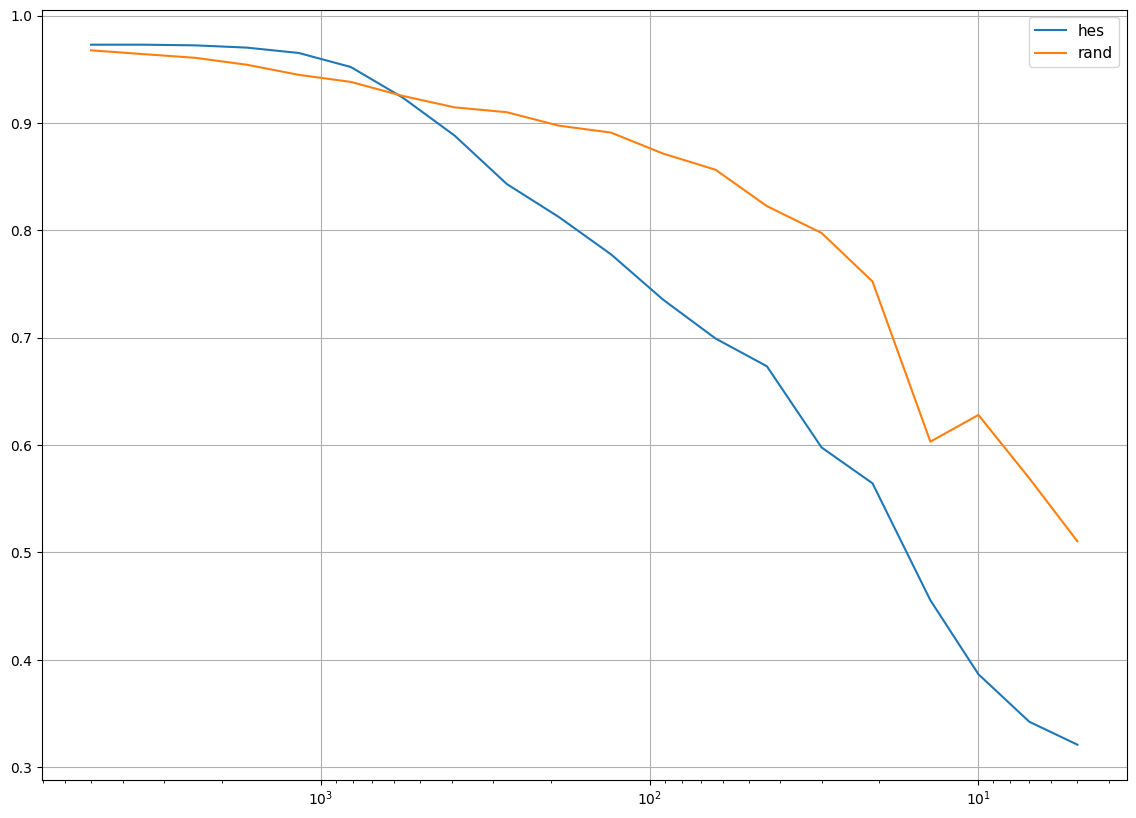

In [404]:
plot_accuracies([hessian_val_acc, random_val_acc], ['hes', 'rand'])

-------------------------------

### retain low input curvature

In [405]:
# input_based_low_val_acc, input_based_low_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', shuffle_seed=1337)

### retain low output curvature

In [406]:
# output_based_low_val_acc, output_based_low_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', curvature_set='output', shuffle_seed=1337)

### compare input vs output curvature approaches

In [407]:
# curves = [output_based_low_val_acc, input_based_low_val_acc, random_val_acc]
# plot_accuracies(curves, ['output_val', 'input_val', 'random'])

### retain high input curvature

In [408]:
# input_based_high_val_acc, input_based_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='high_to_low', shuffle_seed=1337)

### retain high output curvature

In [409]:
output_based_high_val_acc, output_based_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='high_to_low', curvature_set='output', shuffle_seed=1337)

ReducedX.shape: (50000, 28, 28)
  train acc = 0.9940000176429749 val acc = 0.9696999788284302
  train acc = 0.9937999844551086 val acc = 0.9714000225067139
  train acc = 0.9930999875068665 val acc = 0.9699000120162964
  train acc = 0.9934599995613098 val acc = 0.9711999893188477
  train acc = 0.9924200177192688 val acc = 0.9695000052452087
ReducedX.shape: (34760, 28, 28)
  train acc = 0.9938434958457947 val acc = 0.9653000235557556
  train acc = 0.9922899603843689 val acc = 0.9635999798774719
  train acc = 0.9926639795303345 val acc = 0.9645000100135803
  train acc = 0.9930379986763 val acc = 0.9657999873161316
  train acc = 0.9936420917510986 val acc = 0.9650999903678894
ReducedX.shape: (24160, 28, 28)
  train acc = 0.9903973340988159 val acc = 0.9591000080108643
  train acc = 0.9906042814254761 val acc = 0.961899995803833
  train acc = 0.9918460249900818 val acc = 0.9620000123977661
  train acc = 0.9896937012672424 val acc = 0.9595999717712402
  train acc = 0.9888659119606018 val acc

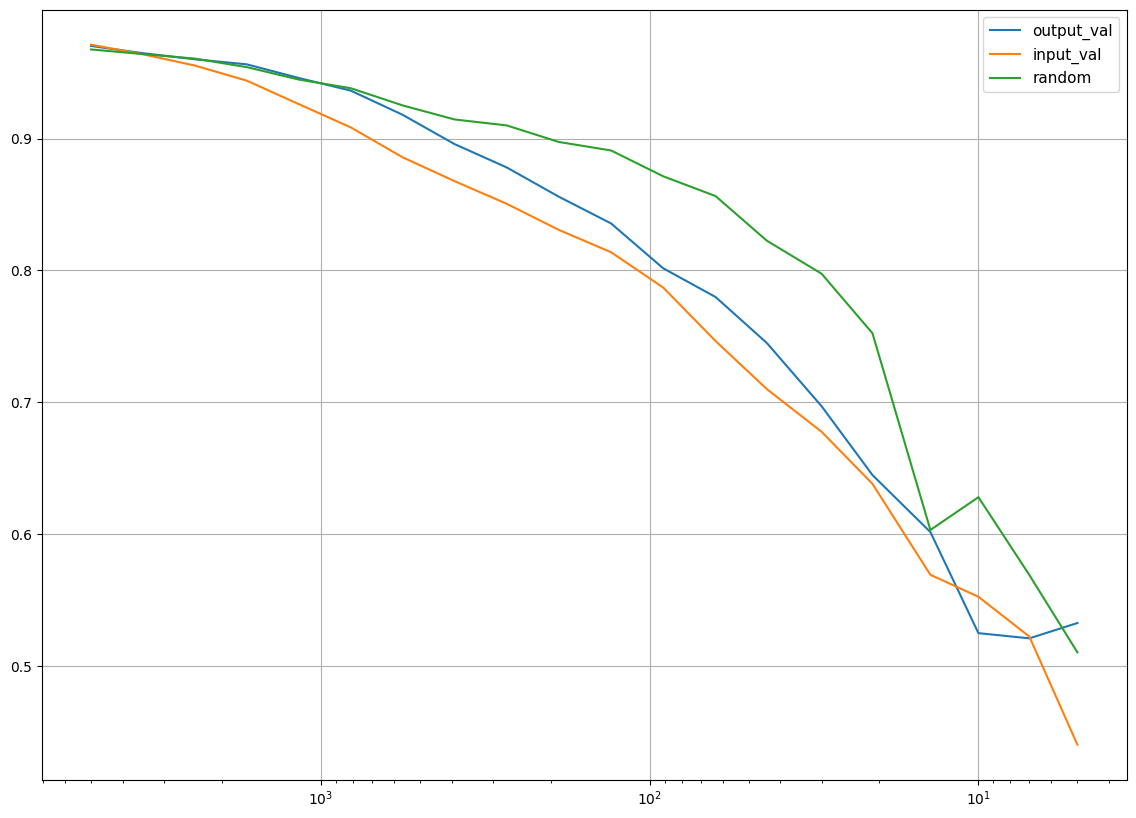

In [410]:
curves = [output_based_high_val_acc, input_based_high_val_acc, random_val_acc]# [output_based_high_val_acc, input_based_high_val_acc, random_val_acc]
plot_accuracies(curves, ['output_val', 'input_val', 'random'])

### retain low and high input curvature

In [411]:
# input_based_low_high_val_acc, input_based_low_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='extremes', shuffle_seed=1337)

### retain low and high output curvature

In [412]:
# output_based_low_high_val_acc, output_based_low_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='extremes', curvature_set='output', shuffle_seed=1337)

In [413]:
# curves = [output_based_low_high_val_acc, input_based_low_high_val_acc, random_val_acc]
# plot_accuracies(curves, ['output_val', 'input_val', 'random'])

### retain mid-range input curvature

In [414]:
# input_based_mid_val_acc, input_based_mid_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='mid', shuffle_seed=1337)

### retain mid-range output curvature

In [415]:
# output_based_mid_val_acc, output_based_mid_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='mid', curvature_set='output', shuffle_seed=1337)

In [416]:
# curves = [output_based_mid_val_acc, input_based_mid_val_acc, random_val_acc]
# plot_accuracies(curves, ['output_val', 'input_val', 'random'])

In [417]:
ratio_low_val_acc, ratio_low_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='ratio_low_to_high', shuffle_seed=1337)

ReducedX.shape: (50000, 28, 28)
  train acc = 0.9932399988174438 val acc = 0.974399983882904
  train acc = 0.9915599822998047 val acc = 0.9713000059127808
  train acc = 0.9920200109481812 val acc = 0.9710000157356262
  train acc = 0.9915000200271606 val acc = 0.9700000286102295
  train acc = 0.9927200078964233 val acc = 0.9710999727249146
ReducedX.shape: (34760, 28, 28)
  train acc = 0.9900748133659363 val acc = 0.9692999720573425
  train acc = 0.9898734092712402 val acc = 0.9664000272750854
  train acc = 0.9894994497299194 val acc = 0.9684000015258789
  train acc = 0.9904487729072571 val acc = 0.9681000113487244
  train acc = 0.9884349703788757 val acc = 0.9671000242233276
ReducedX.shape: (24160, 28, 28)
  train acc = 0.9845198392868042 val acc = 0.9642000198364258
  train acc = 0.9843956828117371 val acc = 0.9643999934196472
  train acc = 0.9815811514854431 val acc = 0.9613999724388123
  train acc = 0.9840231537818909 val acc = 0.9642000198364258
  train acc = 0.9833609461784363 val 

In [418]:
ratio_high_val_acc, ratio_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='ratio_high_to_low', shuffle_seed=1337)

ReducedX.shape: (50000, 28, 28)
  train acc = 0.9945600032806396 val acc = 0.9725000262260437
  train acc = 0.9948199987411499 val acc = 0.9721999764442444
  train acc = 0.9942399859428406 val acc = 0.9700999855995178
  train acc = 0.9937000274658203 val acc = 0.968500018119812
  train acc = 0.9940999746322632 val acc = 0.9706000089645386
ReducedX.shape: (34760, 28, 28)
  train acc = 0.9935845732688904 val acc = 0.9679999947547913
  train acc = 0.9935845732688904 val acc = 0.9642999768257141
  train acc = 0.9927502870559692 val acc = 0.9666000008583069
  train acc = 0.9947640895843506 val acc = 0.9679999947547913
  train acc = 0.9933832287788391 val acc = 0.9621999859809875
ReducedX.shape: (24160, 28, 28)
  train acc = 0.9903145432472229 val acc = 0.9620000123977661
  train acc = 0.9927980303764343 val acc = 0.9617000222206116
  train acc = 0.9902731776237488 val acc = 0.9595999717712402
  train acc = 0.9888244867324829 val acc = 0.9595999717712402
  train acc = 0.9914321303367615 val 

### compare all output based strategies

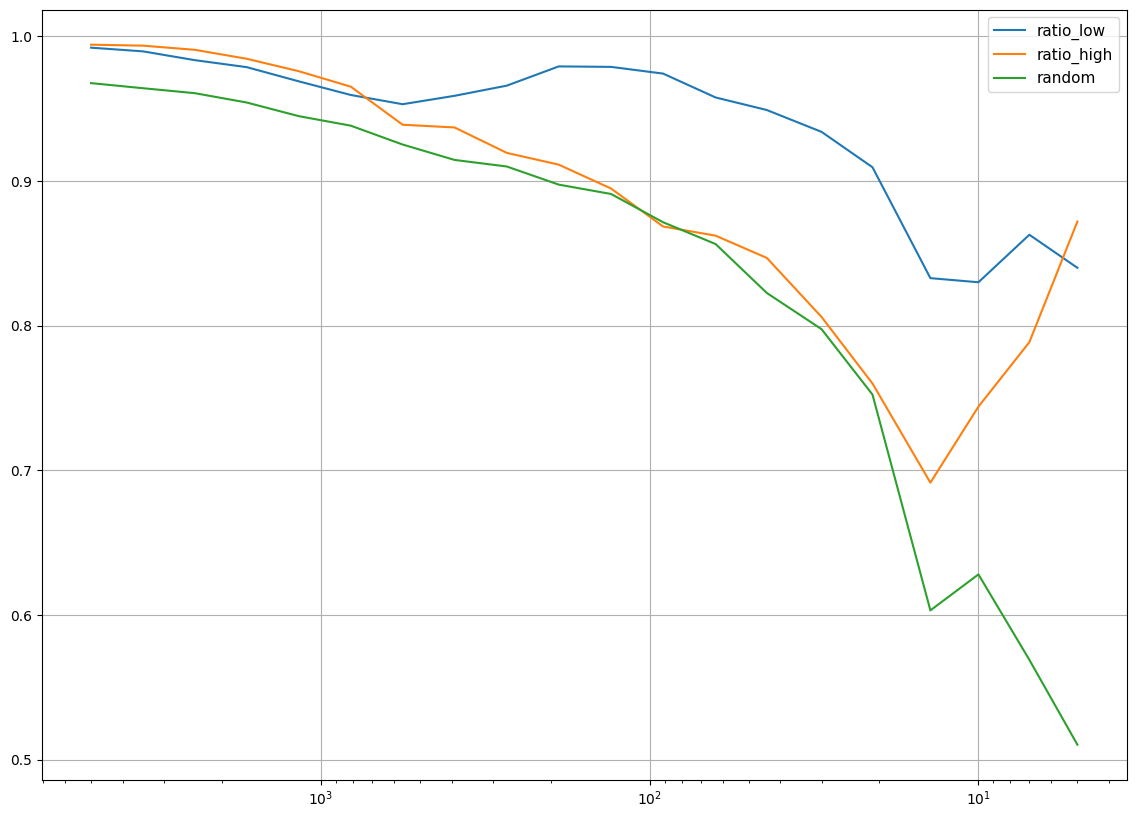

In [419]:
plot_accuracies([ratio_low_acc, ratio_high_acc, random_val_acc], ['ratio_low', 'ratio_high', 'random'])

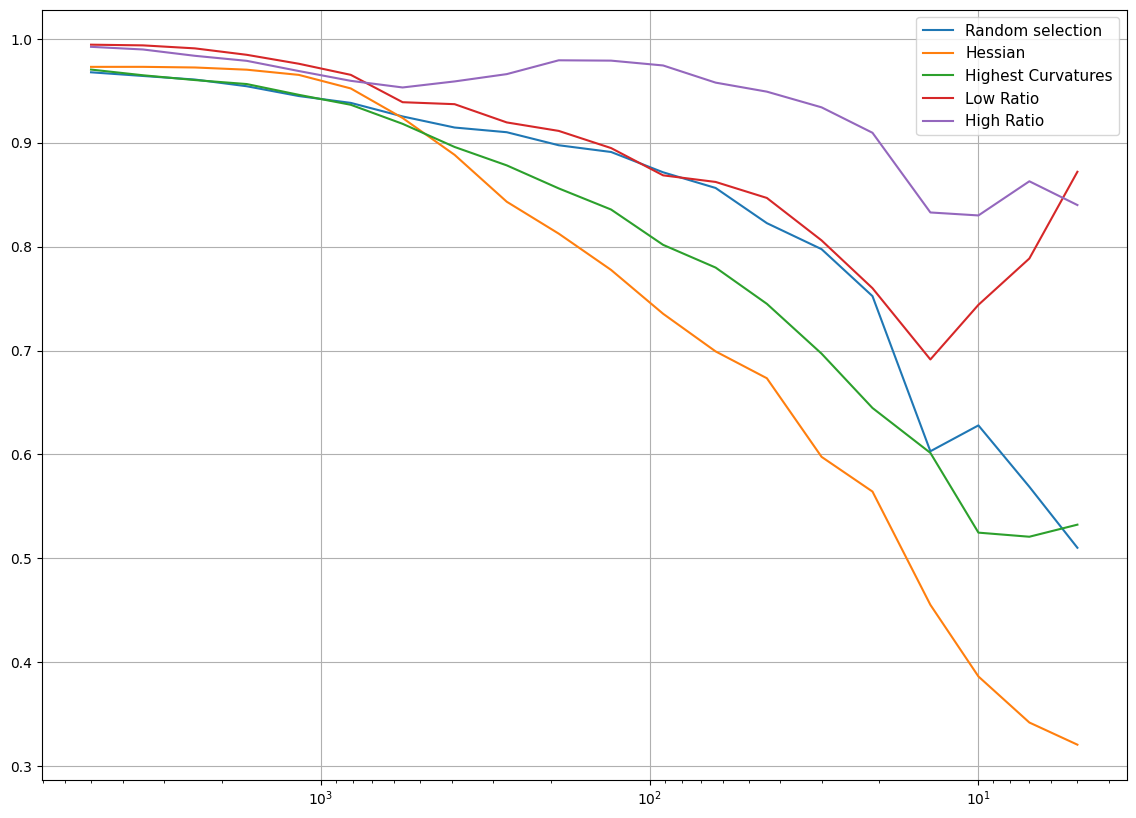

In [420]:
# namelist = ['Random selection', 'Hessian', 'Highest Curvatures', 'Lowest Curvatures', 'Highest + Lowest Curvatures', 'Mid-Range Curvatures', 'Low Ratio', 'High Ratio']
# accuracy_list = [random_val_acc, hessian_val_acc, output_based_high_val_acc, output_based_low_val_acc, output_based_low_high_val_acc, output_based_mid_val_acc, ratio_high_acc, ratio_low_acc]
namelist = ['Random selection', 'Hessian', 'Highest Curvatures', 'Low Ratio', 'High Ratio']
accuracy_list = [random_val_acc, hessian_val_acc, output_based_high_val_acc, ratio_high_acc, ratio_low_acc]
plot_accuracies(accuracy_list, namelist)

### finer grain analysis on best performers

ReducedX.shape: (50000, 28, 28)
  train acc = 0.9960799813270569 val acc = 0.9643999934196472
  train acc = 0.9958800077438354 val acc = 0.9671000242233276
  train acc = 0.9954000115394592 val acc = 0.9674000144004822
  train acc = 0.9967799782752991 val acc = 0.9689000248908997
  train acc = 0.9958800077438354 val acc = 0.9684000015258789
  train acc = 0.9965400099754333 val acc = 0.9674999713897705
  train acc = 0.9968799948692322 val acc = 0.9682999849319458
  train acc = 0.9962599873542786 val acc = 0.9696000218391418
  train acc = 0.9955000281333923 val acc = 0.9664999842643738
  train acc = 0.9962999820709229 val acc = 0.9670000076293945
ReducedX.shape: (40200, 28, 28)
  train acc = 0.9961691498756409 val acc = 0.9678999781608582
  train acc = 0.9961193799972534 val acc = 0.9682000279426575
  train acc = 0.9956716299057007 val acc = 0.9646000266075134
  train acc = 0.995049774646759 val acc = 0.9656999707221985
  train acc = 0.9950000047683716 val acc = 0.9638000130653381
  train

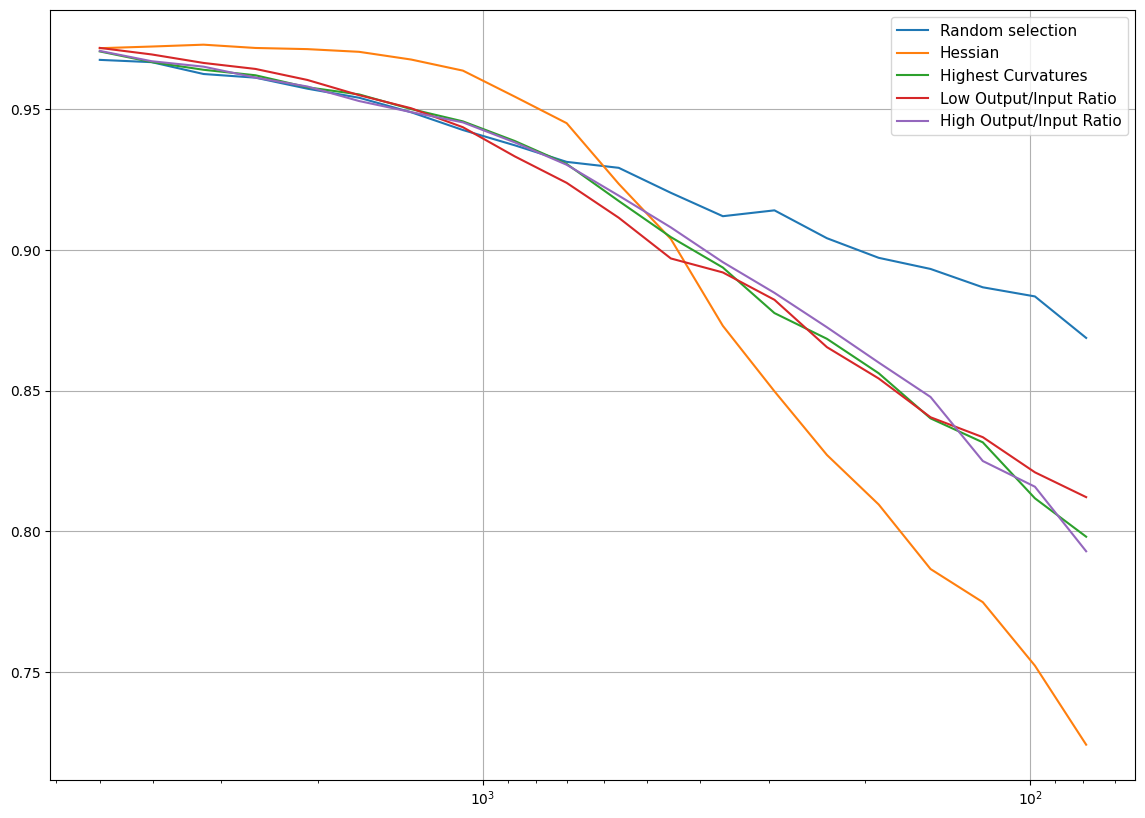

In [422]:
namelist = ['Random selection', 'Hessian', 'Highest Curvatures', 'Low Output/Input Ratio', 'High Output/Input Ratio']
datasizes = np.logspace(3.699, 1.899, 20).astype('int')

rand, _ = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='random', num_models=10)
hess, _ = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='hessian', num_models=10)
high, _ = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='high_to_low', curvature_set='output', shuffle_seed=1337, num_models=10)
ratio_low, _ = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='ratio_low_to_high', shuffle_seed=1337, num_models=10)
ratio_high, _ = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='ratio_high_to_low', shuffle_seed=1337, num_models=10)

plot_accuracies([rand, hess, high, ratio_low, ratio_high], namelist)


### close up on ratio tests

In [ ]:
namelist = ['Random selection', 'Hessian', 'Low Output/Input Ratio', 'High Output/Input Ratio']
datasizes = np.logspace(3.699, 2.599, 20).astype('int')

rand, _ = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='random', num_models=15)
hess, _ = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='hessian', num_models=15)
ratio_low, _ = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='ratio_low_to_high', shuffle_seed=1337, num_models=15)
ratio_high, _ = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='ratio_high_to_low', shuffle_seed=1337, num_models=15)

plot_accuracies([rand, hess, ratio_low, ratio_high], namelist)

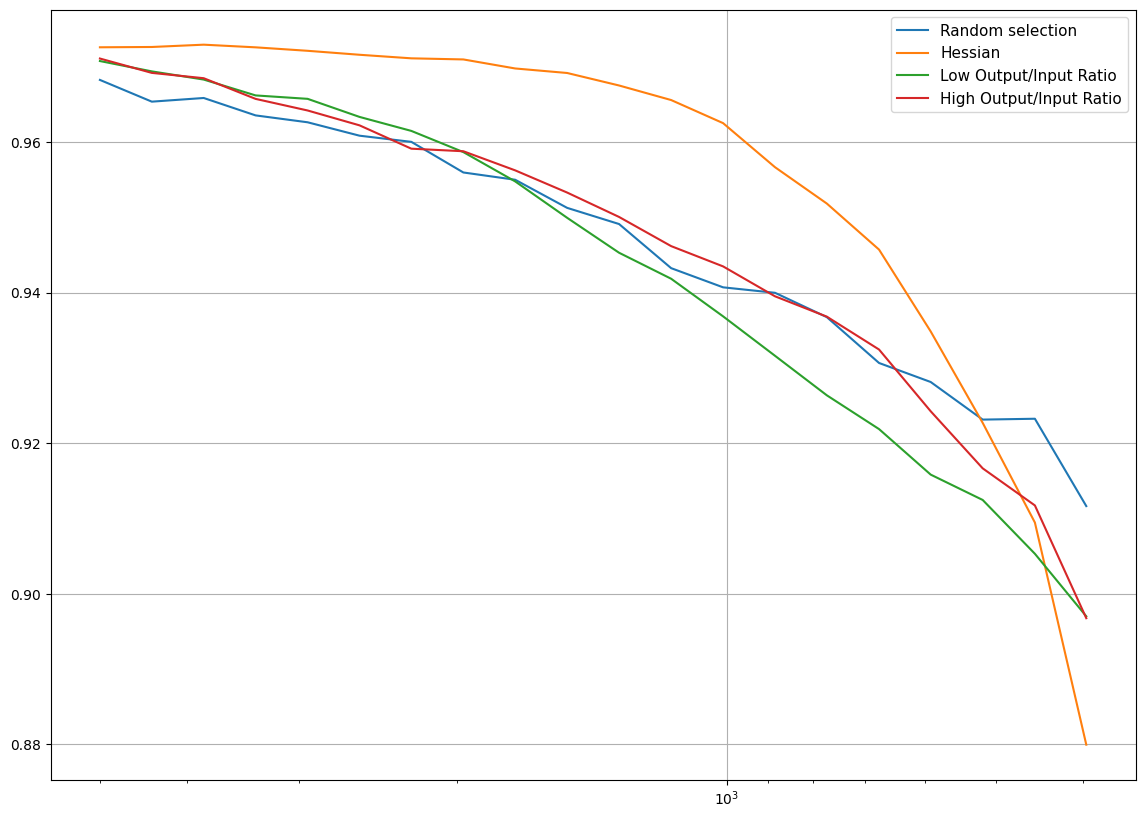

In [20]:
plot_accuracies([rand, hess, ratio_low, ratio_high], namelist)

In [37]:
np.logspace(3.699, 2.599, 20).astype('int')

array([5000, 4376, 3830, 3352, 2933, 2567, 2247, 1966, 1721, 1506, 1318,
       1153, 1009,  883,  773,  676,  592,  518,  453,  397])

In [38]:
print(f'ratio high @ 16% reduction: {ratio_high[2][-1]}')
print(f'ratio low @ 16% reduction: {ratio_low[2][-1]}')
print(f'hessian @ 16% reduction: {hess[2][-1]}')
print(f'random @ 16% reduction: {rand[2][-1]}')

ratio high @ 16% reduction: 0.9682000279426575
ratio low @ 16% reduction: 0.9670000076293945
hessian @ 16% reduction: 0.9743000268936157
random @ 16% reduction: 0.9649999737739563


In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
namelist = []
valacclist = [[]]
valacclist
namelist.append('Random selection')

name = str(namelist[-1])  #'WideResNet-70-16'

valacclist.append([])
for data_size in datasizes:
  indices = np.argsort(input_class_curvatures[0][:,0])[-data_size:]
  Reduced_X_train = X_train[train_y==0][indices]
  Reduced_Y_train = Y_train[train_y==0][indices]
  for y_class in range(1,10):
    indices = np.argsort(input_class_curvatures[y_class][:,0])[-data_size:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==y_class][indices] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==y_class][indices] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Highest Curvatures')

name = str(namelist[-1])  #'WideResNet-70-16'

valacclist.append([])
for data_size in datasizes:
  indices  = np.argsort(input_class_curvatures[0][:,0])[:data_size]
  Reduced_X_train = X_train[train_y==0][indices]
  Reduced_Y_train = Y_train[train_y==0][indices]
  for y_class in range(1,10):
    indices = indices = np.argsort(input_class_curvatures[y_class][:,0])[:data_size]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==y_class][indices] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==y_class][indices] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Lowest Curvatures')

name = str(namelist[-1])  #'WideResNet-70-16'

valacclist.append([])
for data_size in datasizes:
  low_data_size = (data_size//2).astype('int')
  high_data_size = (data_size - low_data_size).astype('int')
  indices  = np.argsort(input_class_curvatures[0][:,0])[:low_data_size]
  high_curvature_indices  = np.argsort(input_class_curvatures[0][:,0])[-high_data_size:]
  Reduced_X_train = X_train[train_y==0][indices]
  Reduced_Y_train = Y_train[train_y==0][indices]
  Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==0][high_curvature_indices] ])
  Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==0][high_curvature_indices] ])
  for y_class in range(1,10):
    indices  = np.argsort(input_class_curvatures[y_class][:,0])[:low_data_size]
    high_curvature_indices  = np.argsort(input_class_curvatures[y_class][:,0])[-high_data_size:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==y_class][indices] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==y_class][indices] ])
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==y_class][high_curvature_indices] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==y_class][high_curvature_indices] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Highest+Lowest Curvatures')

name = str(namelist[-1])  #'WideResNet-70-16'

valacclist.append([])
for data_size in datasizes:
  low_data_size = (data_size//2).astype('int')
  high_data_size = (data_size - low_data_size).astype('int')
  indices  = np.argsort(input_class_curvatures[0][:,0])[input_class_curvatures[0][:,0].shape[0]//2 -low_data_size : input_class_curvatures[0][:,0].shape[0]//2 +high_data_size]
  #indicies2  = np.argsort(classcurvatures[0][:,0])[:]
  Reduced_X_train = X_train[train_y==0][indices]
  Reduced_Y_train = Y_train[train_y==0][indices]
  #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==0][indicies2] ])
  #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==0][indicies2] ])
  for y_class in range(1,10):
    indices  = np.argsort(input_class_curvatures[y_class][:,0])[input_class_curvatures[y_class][:,0].shape[0]//2 -low_data_size : input_class_curvatures[y_class][:,0].shape[0]//2 +high_data_size]
    #indicies2  = np.argsort(classcurvatures[c][:,0])[-datasize2:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==y_class][indices] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==y_class][indices] ])
    #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies2] ])
    #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies2] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Mid-Range Curvatures')

name = str(namelist[-1])  #'WideResNet-70-16'

valacclist.append([])
for data_size in datasizes:
  indices = np.random.choice(X_train[train_y==0].shape[0],data_size,replace=True,p=input_class_curvatures[0][:,0]/np.sum(input_class_curvatures[0][:,0]) )
  Reduced_X_train = X_train[train_y==0][indices]
  Reduced_Y_train = Y_train[train_y==0][indices]
  for y_class in range(1,10):
    indices = np.random.choice(Y_train[train_y==y_class].shape[0],data_size,replace=True)
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==y_class][indices] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==y_class][indices] ])
  print(Reduced_X_train.shape)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Semi-Random selection')

name = str(namelist[-1])  #'WideResNet-70-16'

#plt.plot(datasizes,acclist,'--')
#plt.plot(datasizes,valacclist,'--')
#plt.plot(datasizes,acclist_curv)
plt.figure(figsize=(14, 10))
for curve in valacclist:
  plt.plot(datasizes,np.mean(curve,axis=1))
plt.legend(namelist,fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

In [ ]:
valacclist.append([])
for data_size in datasizes:
  space = np.linspace(0,input_class_curvatures[0][:,0].shape[0]-1,data_size,endpoint=True).astype('int')
  indices  = np.argsort(input_class_curvatures[0][:,0])[space]
  #indicies2  = np.argsort(classcurvatures[0][:,0])[:]
  Reduced_X_train = X_train[train_y==0][indices]
  Reduced_Y_train = Y_train[train_y==0][indices]
  #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==0][indicies2] ])
  #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==0][indicies2] ])
  for y_class in range(1,10):
    space = np.linspace(0,input_class_curvatures[y_class][:,0].shape[0]-1,data_size,endpoint=True).astype('int')
    indices  = np.argsort(input_class_curvatures[y_class][:,0])[space]
    #indicies2  = np.argsort(classcurvatures[c][:,0])[-datasize2:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==y_class][indices] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==y_class][indices] ])
    #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies2] ])
    #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies2] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  nt = create_model()
  #nt.summary()
  #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
  nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
  history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
  print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
  valacclist[-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Equal Spacing')

(50000, 28, 28)
  train acc = 0.9926999807357788 val acc = 0.9732000231742859
(34760, 28, 28)
  train acc = 0.9921461343765259 val acc = 0.9677000045776367
(24160, 28, 28)
  train acc = 0.9880380630493164 val acc = 0.9606999754905701
(16800, 28, 28)
  train acc = 0.9830357432365417 val acc = 0.9578999876976013
(11670, 28, 28)
  train acc = 0.9811482429504395 val acc = 0.9491000175476074
(8110, 28, 28)
  train acc = 0.9658446311950684 val acc = 0.9376999735832214
(5640, 28, 28)
  train acc = 0.9531915187835693 val acc = 0.9265999794006348
(3920, 28, 28)
  train acc = 0.9563775658607483 val acc = 0.9128000140190125
(2720, 28, 28)
  train acc = 0.9573529362678528 val acc = 0.9118000268936157
(1890, 28, 28)
  train acc = 0.9481481313705444 val acc = 0.9014000296592712
(1310, 28, 28)
  train acc = 0.919847309589386 val acc = 0.890999972820282
(910, 28, 28)
  train acc = 0.91318678855896 val acc = 0.8676000237464905
(630, 28, 28)
  train acc = 0.8761904835700989 val acc = 0.8553000092506409


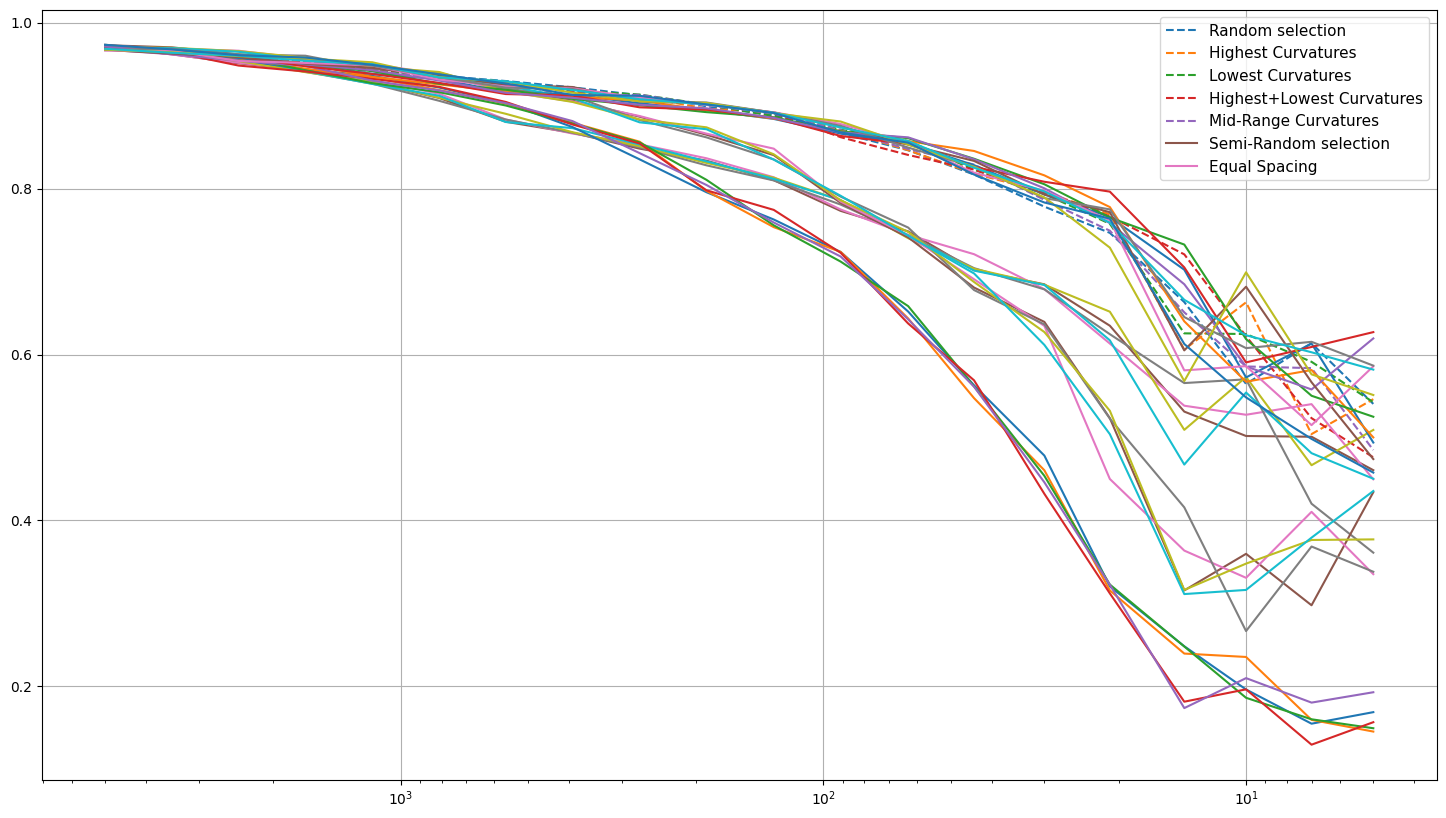

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(datasizes,valacclist[0],'--')
for curve in valacclist[1:]:
  plt.plot(datasizes,curve)
plt.legend(namelist,fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: x and y must have same first dimension, but have shapes (20,) and (7, 20)

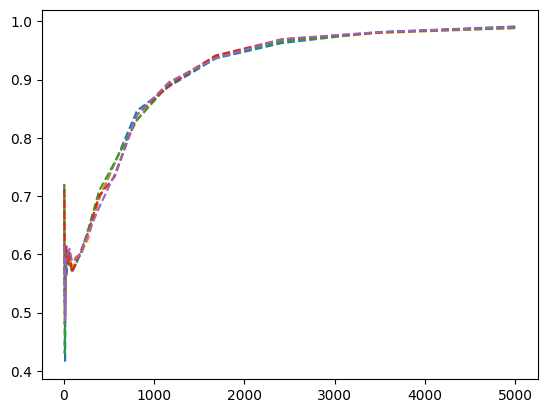

In [ ]:

plt.plot(datasizes,acclist,'--')
plt.plot(datasizes,valacclist,'--')
plt.plot(datasizes,acclist_curv)
plt.plot(datasizes,valacclist_curv)
plt.legend(['acc ','valacc','acc_curv','valaccc_curv'],fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

# cifar

In [ ]:
(cifar_X_train, cifar_train_y), (cifar_X_test, cifar_test_y) = cifar10.load_data()
cifar_X_train = cifar_X_train / 255
cifar_X_test = cifar_X_test/ 255

In [ ]:
cifar_Y_train = np_utils.to_categorical(cifar_train_y, 10)
cifar_Y_test = np_utils.to_categorical(cifar_test_y, 10)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=cifar_X_train.shape[1:], activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
            loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
def create_cifar_model():
  model = Sequential()
  model.add(Conv2D(50, kernel_size=(28,28), input_shape=(32,32,3), activation='PReLU',use_bias=False, kernel_initializer='random_uniform',padding='valid'))
  model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
  model.add(Dense(10, activation='softmax', kernel_initializer= 'random_uniform'))

  return model

In [ ]:
nt = create_cifar_model()
nt.summary()

Model: "sequential_3996"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4005 (Conv2D)        (None, 5, 5, 50)          118850    
                                                                 
 flatten_4070 (Flatten)      (None, 1250)              0         
                                                                 
 dense_3999 (Dense)          (None, 10)                12510     
                                                                 
Total params: 131,360
Trainable params: 131,360
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
history = nt.fit(cifar_X_train, cifar_Y_train, epochs=20, validation_data=(cifar_X_test, cifar_Y_test), verbose=1, batch_size = 128)
print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")

Epoch 1/20
391/391 [==============================] - 18s 34ms/step - loss: 1.5550 - categorical_accuracy: 0.4459 - val_loss: 1.5513 - val_categorical_accuracy: 0.4465
Epoch 2/20
391/391 [==============================] - 9s 23ms/step - loss: 1.5388 - categorical_accuracy: 0.4530 - val_loss: 1.5485 - val_categorical_accuracy: 0.4480
Epoch 3/20
391/391 [==============================] - 10s 25ms/step - loss: 1.5240 - categorical_accuracy: 0.4600 - val_loss: 1.5471 - val_categorical_accuracy: 0.4431
Epoch 4/20
391/391 [==============================] - 9s 24ms/step - loss: 1.5034 - categorical_accuracy: 0.4673 - val_loss: 1.5357 - val_categorical_accuracy: 0.4523
Epoch 5/20
391/391 [==============================] - 9s 23ms/step - loss: 1.4887 - categorical_accuracy: 0.4722 - val_loss: 1.5506 - val_categorical_accuracy: 0.4421
Epoch 6/20
391/391 [==============================] - 9s 22ms/step - loss: 1.4867 - categorical_accuracy: 0.4722 - val_loss: 1.5715 - val_categorical_accuracy: 0.4

In [ ]:
cifar_hessian_list = []
lossfunc = tf.keras.losses.CategoricalCrossentropy()
for i in range(cifar_X_train.shape[0]):
  print(f'calculating hessian {i + 1} of {cifar_X_train.shape[0]}')
  cifar_hessian_list.append(np.linalg.norm(get_hessian2(nt, cifar_X_train[i:i+1], cifar_Y_train[i:i+1], lossfunc=lossfunc)[0]))
cifar_hessian_list = np.array(cifar_hessian_list)

calculating hessian 1 of 50000
calculating hessian 2 of 50000
calculating hessian 3 of 50000
calculating hessian 4 of 50000
calculating hessian 5 of 50000
calculating hessian 6 of 50000
calculating hessian 7 of 50000
calculating hessian 8 of 50000
calculating hessian 9 of 50000
calculating hessian 10 of 50000
calculating hessian 11 of 50000
calculating hessian 12 of 50000
calculating hessian 13 of 50000
calculating hessian 14 of 50000
calculating hessian 15 of 50000
calculating hessian 16 of 50000
calculating hessian 17 of 50000
calculating hessian 18 of 50000
calculating hessian 19 of 50000
calculating hessian 20 of 50000
calculating hessian 21 of 50000
calculating hessian 22 of 50000
calculating hessian 23 of 50000
calculating hessian 24 of 50000
calculating hessian 25 of 50000
calculating hessian 26 of 50000
calculating hessian 27 of 50000
calculating hessian 28 of 50000
calculating hessian 29 of 50000
calculating hessian 30 of 50000
calculating hessian 31 of 50000
calculating hessi

In [ ]:
cifar_Y_predicted = nt.predict(cifar_X_train)

In [ ]:
# define curvatures list
cifar_class_curvatures = []
for y_class in range(10):
  layerfeatlist = [cifar_Y_predicted[cifar_train_y[:, 0] == y_class]]
  results, manifold_neighbour_angle_sum = ManifoldAngles(layerfeatlist, classsize=1, neighboursize1=10, dim_reduc_size=5, fileloc = "None")
  cifar_class_curvatures.append(np.array(manifold_neighbour_angle_sum))

start: 
--layer time:  13.162498950958252
--angle time:  43.920276165008545
Average reduction quality:  0.890757
endtime:  57.224004983901978
start: 
--layer time:  10.49045205116272
--angle time:  40.480427026748657
Average reduction quality:  0.897948444
endtime:  51.026768922805786
start: 
--layer time:  9.3021049499511719
--angle time:  38.331099987030029
Average reduction quality:  0.889877558
endtime:  47.658578157424927
start: 
--layer time:  9.08466911315918
--angle time:  38.249535083770752
Average reduction quality:  0.881253719
endtime:  47.35666298866272
start: 
--layer time:  9.2041110992431641
--angle time:  38.209000110626221
Average reduction quality:  0.88698107
endtime:  47.430893898010254
start: 
--layer time:  9.2642087936401367
--angle time:  50.486844062805176
Average reduction quality:  0.89281261
endtime:  59.879105091094971
start: 
--layer time:  10.231382131576538
--angle time:  41.429099082946777
Average reduction quality:  0.886542261
endtime:  51.6799950599

In [ ]:
datasizes = np.logspace(3.699, 1.899, 20).astype('int')

In [ ]:
# these take a while to train, so I'm breaking them into their own cells to avoid retraining all of them if changes need to be mande to just one
rand, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='random')

ReducedX.shape: (50000, 32, 32, 3)
  train acc = 0.5170800089836121 val acc = 0.43779999017715454
  train acc = 0.5398799777030945 val acc = 0.4458000063896179
  train acc = 0.5352200269699097 val acc = 0.4577000141143799
  train acc = 0.5230200290679932 val acc = 0.43639999628067017
  train acc = 0.5328599810600281 val acc = 0.4544999897480011
ReducedX.shape: (40200, 32, 32, 3)
  train acc = 0.5195770859718323 val acc = 0.41609999537467957
  train acc = 0.5168656706809998 val acc = 0.4074999988079071
  train acc = 0.5127611756324768 val acc = 0.43309998512268066
  train acc = 0.5257711410522461 val acc = 0.4196000099182129
  train acc = 0.5102487802505493 val acc = 0.42989999055862427
ReducedX.shape: (32320, 32, 32, 3)
  train acc = 0.5058168172836304 val acc = 0.4456000030040741
  train acc = 0.4903465211391449 val acc = 0.4341000020503998
  train acc = 0.5148205161094666 val acc = 0.4433000087738037
  train acc = 0.5244430899620056 val acc = 0.4332999885082245
  train acc = 0.516336

In [ ]:
hess, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='hessian')

ReducedX.shape: (50000, 32, 32, 3)
  train acc = 0.5095199942588806 val acc = 0.4724000096321106
  train acc = 0.4927000105381012 val acc = 0.46459999680519104
  train acc = 0.4994400143623352 val acc = 0.4771000146865845
  train acc = 0.5037199854850769 val acc = 0.4697999954223633
  train acc = 0.487199991941452 val acc = 0.4584999978542328
ReducedX.shape: (40200, 32, 32, 3)
  train acc = 0.5269402861595154 val acc = 0.4578000009059906
  train acc = 0.5385074615478516 val acc = 0.4602999985218048
  train acc = 0.5395273566246033 val acc = 0.46810001134872437
  train acc = 0.5406965017318726 val acc = 0.4778999984264374
  train acc = 0.5442288517951965 val acc = 0.4401000142097473
ReducedX.shape: (32320, 32, 32, 3)
  train acc = 0.549845278263092 val acc = 0.45350000262260437
  train acc = 0.5519183278083801 val acc = 0.4555000066757202
  train acc = 0.5521039366722107 val acc = 0.46129998564720154
  train acc = 0.546565592288971 val acc = 0.45489999651908875
  train acc = 0.558849036

In [ ]:
keep_high, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='high_to_low', curvature_set='output')

ReducedX.shape: (50000, 32, 32, 3)
  train acc = 0.4968000054359436 val acc = 0.45989999175071716
  train acc = 0.4907200038433075 val acc = 0.47699999809265137
  train acc = 0.4972600042819977 val acc = 0.4722000062465668
  train acc = 0.4974200129508972 val acc = 0.46639999747276306
  train acc = 0.5012199878692627 val acc = 0.46380001306533813
ReducedX.shape: (40200, 32, 32, 3)
  train acc = 0.4763184189796448 val acc = 0.4571000039577484
  train acc = 0.4723631739616394 val acc = 0.4577000141143799
  train acc = 0.4780845642089844 val acc = 0.46389999985694885
  train acc = 0.4625622034072876 val acc = 0.4406000077724457
  train acc = 0.4747263789176941 val acc = 0.45010000467300415
ReducedX.shape: (32320, 32, 32, 3)
  train acc = 0.466769814491272 val acc = 0.4372999966144562
  train acc = 0.458725243806839 val acc = 0.4447000026702881
  train acc = 0.45464110374450684 val acc = 0.4413999915122986
  train acc = 0.4636138677597046 val acc = 0.45159998536109924
  train acc = 0.46113

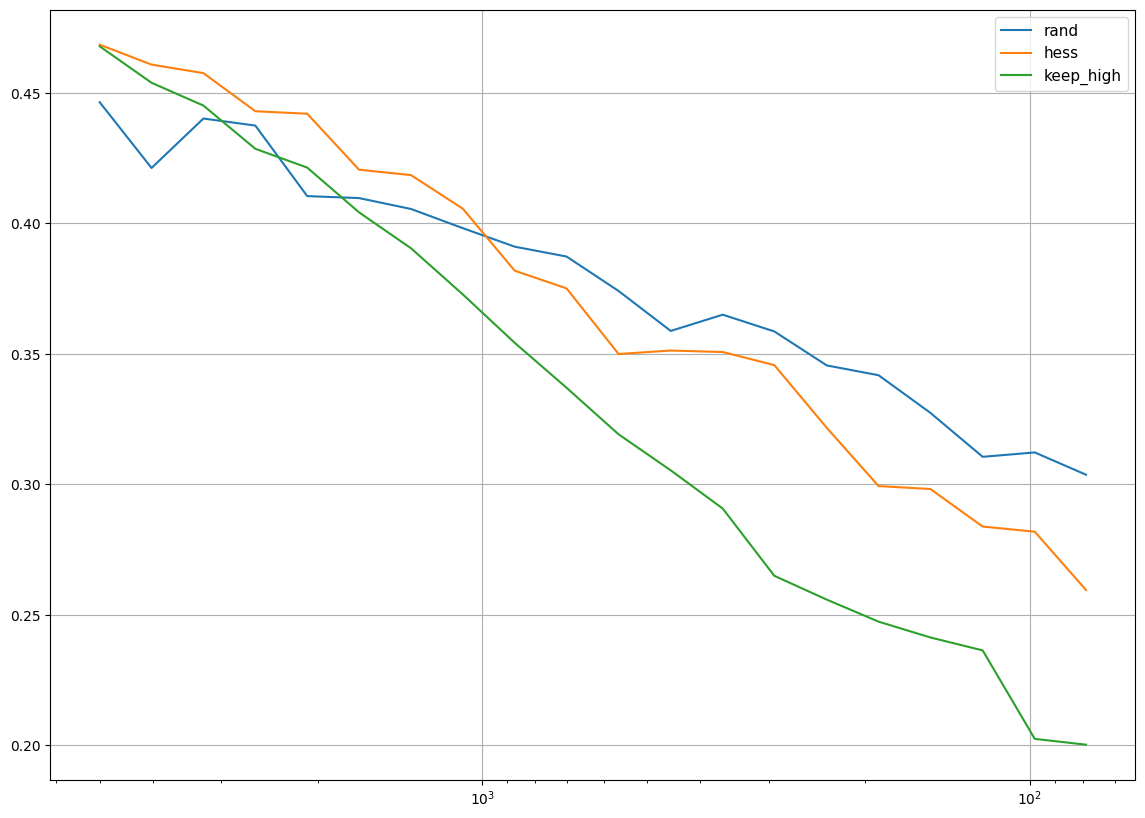

In [ ]:
plot_accuracies([rand, hess, keep_high], ['rand', 'hess', 'keep_high'])